In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
import torch.multiprocessing as mp
import argparse
from torch import optim
import os
import visdom


In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,20,kernel_size=(5,5),stride=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(20,50,kernel_size=(5,5),stride=1)
        self.pool2 =nn.MaxPool2d(2)
        self.fc1 = nn.Linear(800,500)
        self.relu1 = nn.ReLU()
        self.fc2 =nn.Linear(500,10)
        self.relu2 = nn.ReLU()
    def forward(self,x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.relu1(self.fc1(x.view(-1,800)))
        x = self.relu2(self.fc2(x))
        return F.log_softmax(x)

In [122]:
def train(args, model, device, dataloader_kwargs):
    global_step = 0
    #手动设置随机种子
    torch.manual_seed(args.get('seed'))
    #加载训练数据
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../chapter3/data', train=True, download=True,transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.,), (1.,))
                    ])),batch_size=args.get('batch_size'), shuffle=True, num_workers=1,**dataloader_kwargs)
    #使用随机梯度下降进行优化
    optimizer = optim.SGD(model.parameters(), lr=args.get('lr'), momentum=args.get('momentum'))
    #开始训练，训练epoches次
    for epoch in range(1, args.get('epochs') + 1):
        global_step = train_epoch(epoch, args, model, device, train_loader, optimizer,global_step)

def test(args, model, device, dataloader_kwargs):
    #设置随机种子
    torch.manual_seed(args.get('seed'))
    #加载测试数据
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../chapter3/data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.,), (1.,))
        ])),batch_size=args.get('batch_size'), shuffle=True, num_workers=1,**dataloader_kwargs)
    #运行测试
    test_epoch(model, device, test_loader)
    
    
def train_epoch(epoch, args, model, device, data_loader, optimizer,global_step):
    #模型转换为训练模式
    model.train()
    pid = os.getpid()
    for batch_idx, (data, target) in enumerate(data_loader):
        #优化器梯度置0
        optimizer.zero_grad()
        #输入特征预测值
        output = model(data.to(device))
        #预测值与标准值计算损失
        loss = F.nll_loss(output, target.to(device))
        #计算梯度
        loss.backward()
        #更新梯度
        optimizer.step()
        #每10步打印一下日志
        if batch_idx % 10 == 0:
            global_step += 1
            viz.line(Y=np.array([loss.item()]), X=np.array([global_step]), update='append', win=args.get("loss_win"))
            print('{}\tTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(pid, epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
    return global_step


def test_epoch(model, device, data_loader):
    #模型转换为测试模式
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data.to(device))
            #将每个批次的损失加起来
            test_loss += F.nll_loss(output, target.to(device), reduction='sum').item()
            #得到概率最大的索引,
            pred = output.max(1)[1]
            #预测的索引和目标索引相同，认为预测正确
            correct += pred.eq(target.to(device)).sum().item()

    test_loss /= len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))



In [125]:
viz = visdom.Visdom(port=8097, server="127.0.0.1",env="Test")
# line updates
loss_win = viz.line(np.arange(1))

args={
    'batch_size':512,
    'epochs':100,
    'lr':0.01,
    'momentum':0.5,
    'seed':1,
    'log_interval':30,
    'cuda':True,
    'loss_win':loss_win
}

if __name__=="__main__":
    #判断是否使用GPU
    use_cuda = args.get('cuda') and torch.cuda.is_available()
    #运行时设备
    device = torch.device("cuda" if use_cuda else "cpu")
    #使用固定缓冲区
    dataloader_kwargs = {'pin_memory': True} if use_cuda else {}
    model = LeNet().cuda() if use_cuda else LeNet()
    train(args,model,device,dataloader_kwargs)
    test(args, model, device, dataloader_kwargs)

D:\softwares\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


2192	Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307944
2192	Train Epoch: 1 [5120/60000 (8%)]	Loss: 2.292752
2192	Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.284603
2192	Train Epoch: 1 [15360/60000 (25%)]	Loss: 2.272050
2192	Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.257520
2192	Train Epoch: 1 [25600/60000 (42%)]	Loss: 2.238625
2192	Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.220961
2192	Train Epoch: 1 [35840/60000 (59%)]	Loss: 2.203156
2192	Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.163243
2192	Train Epoch: 1 [46080/60000 (76%)]	Loss: 2.136190
2192	Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.099717
2192	Train Epoch: 1 [56320/60000 (93%)]	Loss: 2.012057
2192	Train Epoch: 2 [0/60000 (0%)]	Loss: 1.943501
2192	Train Epoch: 2 [5120/60000 (8%)]	Loss: 1.839903
2192	Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.663127
2192	Train Epoch: 2 [15360/60000 (25%)]	Loss: 1.543957
2192	Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.441138
2192	Train Epoch: 2 [25600/60000 (42%)]	Loss: 1.312943
2192	Train Epoch: 2 [307

2192	Train Epoch: 25 [40960/60000 (68%)]	Loss: 0.268164
2192	Train Epoch: 25 [46080/60000 (76%)]	Loss: 0.300512
2192	Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.271007
2192	Train Epoch: 25 [56320/60000 (93%)]	Loss: 0.243105
2192	Train Epoch: 26 [0/60000 (0%)]	Loss: 0.282887
2192	Train Epoch: 26 [5120/60000 (8%)]	Loss: 0.254658
2192	Train Epoch: 26 [10240/60000 (17%)]	Loss: 0.242220
2192	Train Epoch: 26 [15360/60000 (25%)]	Loss: 0.313689
2192	Train Epoch: 26 [20480/60000 (34%)]	Loss: 0.255744
2192	Train Epoch: 26 [25600/60000 (42%)]	Loss: 0.259870
2192	Train Epoch: 26 [30720/60000 (51%)]	Loss: 0.270391
2192	Train Epoch: 26 [35840/60000 (59%)]	Loss: 0.252899
2192	Train Epoch: 26 [40960/60000 (68%)]	Loss: 0.279015
2192	Train Epoch: 26 [46080/60000 (76%)]	Loss: 0.297439
2192	Train Epoch: 26 [51200/60000 (85%)]	Loss: 0.343756
2192	Train Epoch: 26 [56320/60000 (93%)]	Loss: 0.236656
2192	Train Epoch: 27 [0/60000 (0%)]	Loss: 0.257299
2192	Train Epoch: 27 [5120/60000 (8%)]	Loss: 0.266466
2192	T

2192	Train Epoch: 50 [10240/60000 (17%)]	Loss: 0.047798
2192	Train Epoch: 50 [15360/60000 (25%)]	Loss: 0.027124
2192	Train Epoch: 50 [20480/60000 (34%)]	Loss: 0.019361
2192	Train Epoch: 50 [25600/60000 (42%)]	Loss: 0.033059
2192	Train Epoch: 50 [30720/60000 (51%)]	Loss: 0.049599
2192	Train Epoch: 50 [35840/60000 (59%)]	Loss: 0.061868
2192	Train Epoch: 50 [40960/60000 (68%)]	Loss: 0.033561
2192	Train Epoch: 50 [46080/60000 (76%)]	Loss: 0.044369
2192	Train Epoch: 50 [51200/60000 (85%)]	Loss: 0.046487
2192	Train Epoch: 50 [56320/60000 (93%)]	Loss: 0.028719
2192	Train Epoch: 51 [0/60000 (0%)]	Loss: 0.025807
2192	Train Epoch: 51 [5120/60000 (8%)]	Loss: 0.037096
2192	Train Epoch: 51 [10240/60000 (17%)]	Loss: 0.036061
2192	Train Epoch: 51 [15360/60000 (25%)]	Loss: 0.033781
2192	Train Epoch: 51 [20480/60000 (34%)]	Loss: 0.021504
2192	Train Epoch: 51 [25600/60000 (42%)]	Loss: 0.046102
2192	Train Epoch: 51 [30720/60000 (51%)]	Loss: 0.063019
2192	Train Epoch: 51 [35840/60000 (59%)]	Loss: 0.063311

2192	Train Epoch: 74 [40960/60000 (68%)]	Loss: 0.017162
2192	Train Epoch: 74 [46080/60000 (76%)]	Loss: 0.022123
2192	Train Epoch: 74 [51200/60000 (85%)]	Loss: 0.020568
2192	Train Epoch: 74 [56320/60000 (93%)]	Loss: 0.019765
2192	Train Epoch: 75 [0/60000 (0%)]	Loss: 0.030741
2192	Train Epoch: 75 [5120/60000 (8%)]	Loss: 0.012862
2192	Train Epoch: 75 [10240/60000 (17%)]	Loss: 0.018218
2192	Train Epoch: 75 [15360/60000 (25%)]	Loss: 0.031176
2192	Train Epoch: 75 [20480/60000 (34%)]	Loss: 0.021425
2192	Train Epoch: 75 [25600/60000 (42%)]	Loss: 0.013227
2192	Train Epoch: 75 [30720/60000 (51%)]	Loss: 0.018158
2192	Train Epoch: 75 [35840/60000 (59%)]	Loss: 0.028228
2192	Train Epoch: 75 [40960/60000 (68%)]	Loss: 0.048077
2192	Train Epoch: 75 [46080/60000 (76%)]	Loss: 0.018115
2192	Train Epoch: 75 [51200/60000 (85%)]	Loss: 0.023676
2192	Train Epoch: 75 [56320/60000 (93%)]	Loss: 0.018869
2192	Train Epoch: 76 [0/60000 (0%)]	Loss: 0.025869
2192	Train Epoch: 76 [5120/60000 (8%)]	Loss: 0.035810
2192	T

2192	Train Epoch: 99 [10240/60000 (17%)]	Loss: 0.013563
2192	Train Epoch: 99 [15360/60000 (25%)]	Loss: 0.005070
2192	Train Epoch: 99 [20480/60000 (34%)]	Loss: 0.020456
2192	Train Epoch: 99 [25600/60000 (42%)]	Loss: 0.008158
2192	Train Epoch: 99 [30720/60000 (51%)]	Loss: 0.012548
2192	Train Epoch: 99 [35840/60000 (59%)]	Loss: 0.019775
2192	Train Epoch: 99 [40960/60000 (68%)]	Loss: 0.010992
2192	Train Epoch: 99 [46080/60000 (76%)]	Loss: 0.016445
2192	Train Epoch: 99 [51200/60000 (85%)]	Loss: 0.017096
2192	Train Epoch: 99 [56320/60000 (93%)]	Loss: 0.017508
2192	Train Epoch: 100 [0/60000 (0%)]	Loss: 0.060903
2192	Train Epoch: 100 [5120/60000 (8%)]	Loss: 0.015776
2192	Train Epoch: 100 [10240/60000 (17%)]	Loss: 0.008416
2192	Train Epoch: 100 [15360/60000 (25%)]	Loss: 0.015621
2192	Train Epoch: 100 [20480/60000 (34%)]	Loss: 0.014284
2192	Train Epoch: 100 [25600/60000 (42%)]	Loss: 0.028844
2192	Train Epoch: 100 [30720/60000 (51%)]	Loss: 0.016716
2192	Train Epoch: 100 [35840/60000 (59%)]	Loss: 

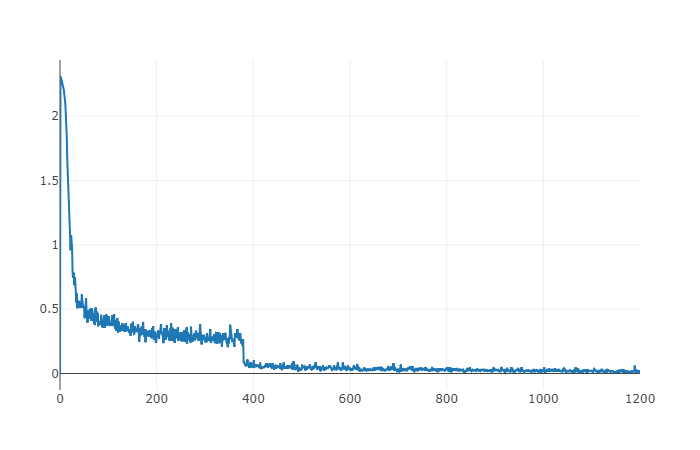

In [126]:
from IPython.display import Image
Image("LeNet.png")

In [6]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu2): ReLU()
)